# 가설 5
- 귀무 가설(H0) :  성공한 게임, 실패한 게임, 복합적인 평가를 받는 게임의 가격 모두 리뷰에 영향을 준다.
- 대립 가설(H1) : 성공한 게임, 실패한 게임, 복합적인 평가를 받는 게임의 가격 모두 리뷰에 영향을 주지 않는다.

### 성공한 게임과 실패한 게임, 복합적인 평가를 받은 게임의 기준
- 성공한 게임
    - 긍정 리뷰 비율(positive_rating_ratio)이 0.7이상
- 실패한 게임
    - 긍정 리뷰 비율(positive_rating_ratio)이 0.5미만
- 복합적인 평가를 받는 게임
    - 긍정 리뷰 비율(positive_rating_ratio)이 0.4이상 0.7미만
    
### 이상치 기준
- 평균 게임 이용시간(average_playtime)의 정상 범위를 30이상 1000 이하로 둠
- 중간 게임 이용시간(median_playtime)의 정상 범위를 30이상 1000 이하로 둠

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import kstest, shapiro, anderson
from scipy.stats import mannwhitneyu, wilcoxon, kruskal

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# 이상치 설정
def average_playtime_setting_outlier(data, min_data, max_data):
    cond1 = data['average_playtime'] >= min_data
    cond2 = data['average_playtime'] <= max_data
    
    data = data[cond1 & cond2]
    
    return data

def median_playtime_setting_outlier(data, min_data, max_data):
    cond1 = data['median_playtime'] >= min_data
    cond2 = data['median_playtime'] <= max_data

    data = data[cond1 & cond2]

    return data

In [3]:
def success_game_range(data, rating_ratio, count_reviews):
    cond1 = data['positive_rating_ratio'] >= rating_ratio
    cond2 = data['total_ratings'] >= count_reviews
    
    data = data[cond1 & cond2]
    
    return data

def mixed_game_range(data, min_ratio, max_ratio, count_reveiws):
    cond1 = data['positive_rating_ratio'] >= min_ratio
    cond2 = data['positive_rating_ratio'] < max_ratio    
    cond3 = data['total_ratings'] >= count_reveiws
    
    data = data[cond1 & cond2 & cond3]
    
    return data

def fail_game_range(data, rating_ratio, count_reviews):
    cond1 = data['positive_rating_ratio'] < rating_ratio
    cond2 = data['total_ratings'] >= count_reviews
    
    data = data[cond1 & cond2]
    
    return data

In [4]:
# t-test 자동화
# 하나의 데이터로 다른 칼럼 t-test
def do_ttest1(data, col1, col2, alternative):
    result_ttest = ttest_ind(data[col1], data[col2], equal_var=False, alternative=alternative)

    return result_ttest
def do_ttest2(data1, data2, col, alternative):
    result_ttest = ttest_ind(data1[col], data2[col], equal_var=False, alternative=alternative)
    
    return result_ttest

In [5]:
df = pd.read_csv('5 Tags in steamspy.csv')
df

,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
0,10,Counter-Strike,2000-11-01,1,True,True,True,Valve,Valve,0,...,0.973888,17612,317,10000000-20000000,7.19,action,fps,multiplayer,shooter,classic
1,20,Team Fortress Classic,1999-04-01,1,True,True,True,Valve,Valve,0,...,0.839787,277,62,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
2,30,Day of Defeat,2003-05-01,1,True,True,True,Valve,Valve,0,...,0.895648,187,34,5000000-10000000,3.99,fps,world_war_ii,multiplayer,action,shooter
3,40,Deathmatch Classic,2001-06-01,1,True,True,True,Valve,Valve,0,...,0.826623,258,184,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
4,50,Half-Life: Opposing Force,1999-11-01,1,True,True,True,Gearbox Software,Valve,0,...,0.947996,624,415,5000000-10000000,3.99,fps,action,sci_fi,singleplayer,classic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,1020340,Audica,2019-03-07,1,True,False,False,"Harmonix Music Systems, Inc","Harmonix Music Systems, Inc",0,...,0.795181,17,17,0-20000,15.49,rhythm,music,vr,early_access,action
6166,1020820,KumaKuma Manga Editor,2019-02-27,1,True,False,False,KumaKumaManga,SakuraGame,0,...,0.894057,43,43,20000-50000,4.79,design_&_illustration,web_publishing,animation_&_modeling,anime,pve
6167,1031480,Ã¦ÂÂ±Ã¦ÂÂ¹Ã¥Â¹ÂÃ¨ÂÂ¯Ã§Â¥Â­ Ã¦ÂÂ¥Ã©ÂÂªÃ§Â...,2019-03-18,1,True,False,False,Ã¤Â¸ÂÃ¦ÂÂ¹Ã¥Â¹ÂÃ¥ÂÂÃ§Â¥Â­Ã¥ÂÂ¶Ã¤Â½ÂÃ§Â»Â,Ã¤Â¸ÂÃ¦ÂÂ¹Ã¥Â¹ÂÃ¥ÂÂÃ§Â¥Â­Ã¥ÂÂ¶Ã¤Â½ÂÃ§Â»Â,0,...,0.970219,154,154,0-20000,10.29,indie,bullet_hell,faith,shoot_em_up,anime
6168,1043180,Lovers of Aether,2019-04-01,1,True,True,False,Dan Fornace,Dan Fornace,0,...,0.957353,12,12,50000-100000,0.00,psychological_horror,dating_sim,casual,indie,free_to_play


In [6]:
data = average_playtime_setting_outlier(df, 30, 1000)
data = median_playtime_setting_outlier(data, 30, 1000)

In [7]:
success_game_data = success_game_range(data, 0.7, 0)
fail_game_data = fail_game_range(data, 0.4, 0)
mixed_game_data = mixed_game_range(data, 0.4, 0.7, 0)

display(success_game_data, fail_game_data, mixed_game_data)

,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
1,20,Team Fortress Classic,1999-04-01,1,True,True,True,Valve,Valve,0,...,0.839787,277,62,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
2,30,Day of Defeat,2003-05-01,1,True,True,True,Valve,Valve,0,...,0.895648,187,34,5000000-10000000,3.99,fps,world_war_ii,multiplayer,action,shooter
3,40,Deathmatch Classic,2001-06-01,1,True,True,True,Valve,Valve,0,...,0.826623,258,184,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
4,50,Half-Life: Opposing Force,1999-11-01,1,True,True,True,Gearbox Software,Valve,0,...,0.947996,624,415,5000000-10000000,3.99,fps,action,sci_fi,singleplayer,classic
7,80,Counter-Strike: Condition Zero,2004-03-01,1,True,True,True,Valve,Valve,0,...,0.893871,427,43,10000000-20000000,7.19,action,fps,multiplayer,shooter,singleplayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,994220,NEOVERSE,2019-01-09,1,True,True,False,Tinogames Inc.,Tinogames Inc.,0,...,0.811321,162,162,0-20000,13.99,strategy,early_access,indie,card_game,rogue_lite
6157,994280,Ã¥ÂÂ¤Ã¥ÂÂÃ¥Â¥ÂÃ¨Â°Â­Ã¤Â¸Â(Gujian3),2018-12-14,0,True,False,False,Ã¤Â¸ÂÃ¦ÂµÂ·Ã§ÂÂÃ©Â¾ÂÃ¤Â¿Â¡Ã¦ÂÂ¯Ã§Â§ÂÃ¦Â...,Ã¥ÂÂÃ¤ÂºÂ¬Ã§Â½ÂÃ¥Â ÂÃ¥ÂÂ£Ã¥ÂÂÃ¥Â¨Â±Ã¤Â¹...,0,...,0.826923,614,823,100000-200000,23.79,rpg,action_rpg,story_rich,singleplayer,action
6158,995460,Miracle snack shop ÃªÂ¸Â°Ã¬Â ÂÃ¬ÂÂ Ã«Â¶ÂÃ¬...,2018-12-25,1,True,False,False,"TALESSHOP Co., Ltd.","TALESSHOP Co., Ltd.",0,...,0.973827,816,816,20000-50000,7.19,dating_sim,visual_novel,simulation,sexual_content,anime
6166,1020820,KumaKuma Manga Editor,2019-02-27,1,True,False,False,KumaKumaManga,SakuraGame,0,...,0.894057,43,43,20000-50000,4.79,design_&_illustration,web_publishing,animation_&_modeling,anime,pve


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
180,10220,Postal III,2012-02-17,1,True,False,False,Trashmasters,Akella,18,...,0.367968,411,411,50000-100000,8.99,action,dark_humor,gore,open_world,funny
193,11590,Hospital Tycoon,2009-02-13,1,True,False,False,Deep Red Limited,Codemasters,0,...,0.367647,119,176,200000-500000,3.49,simulation,management,singleplayer,1980s,puzzle_platformer
361,27330,Blacklight: Tango Down,2010-07-14,1,True,False,False,Zombie Studios,Ignition Entertainment,0,...,0.387097,129,193,50000-100000,0.79,action,fps,multiplayer,1980s,quick_time_events
365,27940,Dead Horde,2011-07-27,1,True,False,False,DnS Development,DnS Development,0,...,0.336601,82,82,50000-100000,4.79,action,zombies,indie,survival,multiplayer
506,46540,Trapped Dead,2011-07-15,1,True,False,False,Headup Games / Crenetic,Headup Games,0,...,0.386228,142,157,100000-200000,3.99,zombies,strategy,action,adventure,co_op
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6033,843500,God Vs Zombies,2018-05-10,1,True,False,False,Kev Jackson,Kev Jackson,0,...,0.265306,60,60,0-20000,2.89,early_access,action,strategy,simulation,indie
6112,911400,Assassin's CreedÃÂ® III Remastered,2019-03-29,1,True,False,False,Ubisoft Entertainment,Ubisoft Entertainment\t\t\t\t,0,...,0.325789,80,80,50000-100000,33.99,action,adventure,assassin,open_world,1980s
6117,921590,DISSIDIA FINAL FANTASY NT Free Edition,2019-03-12,1,True,False,False,"Square Enix;KOEI TECMO GAMES CO., LTD.",Square Enix,0,...,0.381538,285,289,200000-500000,0.00,free_to_play,action,multiplayer,fighting,anime
6135,950100,PRO EVOLUTION SOCCER 2019 LITE,2018-12-13,1,True,False,False,Konami Digital Entertainment,Konami Digital Entertainment,0,...,0.399057,106,83,200000-500000,0.00,sports,free_to_play,multiplayer,soccer,singleplayer


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
33,1690,Space Empires V,2006-10-16,1,True,False,False,Malfador Machinations,Strategy First,0,...,0.692029,35,35,50000-100000,10.99,strategy,4x,space,sci_fi,turn_based
36,1900,Earth 2160,2006-04-01,1,True,True,True,Reality Pump Studios,Topware Interactive;ACE,0,...,0.676630,405,414,1000000-2000000,3.99,strategy,rts,sci_fi,singleplayer,multiplayer
87,4520,Full Spectrum Warrior,2007-07-17,1,True,False,False,Pandemic Studios,THQ Nordic,0,...,0.638554,124,244,100000-200000,7.99,strategy,action,military,tactical,singleplayer
98,4890,Cossacks II: Battle for Europe,2011-08-26,1,True,False,False,GSC Game World,GSC World Publishing,0,...,0.640625,71,71,100000-200000,3.99,strategy,rts,historical,puzzle,racing
115,6550,Devil May CryÃÂ® 3 Special Edition,2007-06-12,1,True,False,False,"CAPCOM Co., Ltd.",Capcom,0,...,0.581543,90,90,200000-500000,15.99,action,hack_and_slash,great_soundtrack,stylized,spectacle_fighter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6116,921060,Modern Combat 5,2018-10-24,1,True,False,False,Gameloft,Gameloft,0,...,0.432135,129,69,200000-500000,0.00,free_to_play,massively_multiplayer,fps,action,shooter
6118,921630,Ã©ÂÂ³Ã§ÂÂµ INVAXION,2018-12-19,1,True,False,False,Nanjing AQUATRAX,bilibili,0,...,0.547649,760,760,100000-200000,11.29,music,rhythm,indie,casual,anime
6141,964470,Shakes and Fidget Remastered,2018-11-22,1,True,False,False,Playa Games GmbH,Playa Games GmbH,0,...,0.652733,50,91,50000-100000,0.00,free_to_play,casual,rpg,strategy,indie
6147,969880,Terrible Beast from the East,2019-01-03,1,True,False,False,Sleeping Hero,SakuraGame,0,...,0.488095,53,53,0-20000,1.69,action,massively_multiplayer,adventure,rpg,1980s


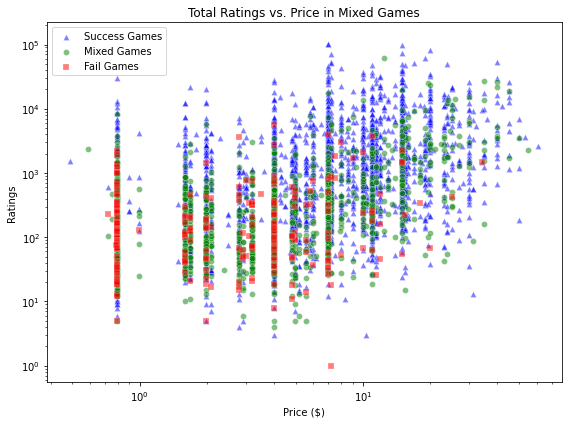

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting all three datasets on the same axes, with different colors
sns.scatterplot(x='price', y='total_ratings', data=success_game_data, alpha=0.5, ax=ax, color="blue", marker = '^', label="Success Games")
sns.scatterplot(x='price', y='total_ratings', data=mixed_game_data, alpha=0.5, ax=ax, color="green", marker = 'o', label="Mixed Games")
sns.scatterplot(x='price', y='total_ratings', data=fail_game_data, alpha=0.5, ax=ax, color="red", marker = 's', label="Fail Games")

ax.set_title('Total Ratings vs. Price in Mixed Games')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Ratings')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
alter_list = ['two-sided', 'less', 'greater']

for alter in alter_list:
    result = do_ttest1(success_game_data, 'average_playtime', 'median_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest1(fail_game_data, 'average_playtime', 'median_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest2(success_game_data, fail_game_data, 'average_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest2(success_game_data, fail_game_data, 'median_playtime', alter)

    print(result)

Ttest_indResult(statistic=-1.92705548219765, pvalue=0.05402144425133013)
Ttest_indResult(statistic=-1.92705548219765, pvalue=0.027010722125665066)
Ttest_indResult(statistic=-1.92705548219765, pvalue=0.9729892778743349)
----------------------
Ttest_indResult(statistic=-1.1126645895346656, pvalue=0.266414112527562)
Ttest_indResult(statistic=-1.1126645895346656, pvalue=0.133207056263781)
Ttest_indResult(statistic=-1.1126645895346656, pvalue=0.866792943736219)
----------------------
Ttest_indResult(statistic=4.925651407391814, pvalue=1.280301177405604e-06)
Ttest_indResult(statistic=4.925651407391814, pvalue=0.9999993598494112)
Ttest_indResult(statistic=4.925651407391814, pvalue=6.40150588702802e-07)
----------------------
Ttest_indResult(statistic=4.708906004192572, pvalue=3.5299107724437355e-06)
Ttest_indResult(statistic=4.708906004192572, pvalue=0.9999982350446137)
Ttest_indResult(statistic=4.708906004192572, pvalue=1.7649553862218678e-06)


In [10]:
success_game_data2 = success_game_data[success_game_data['price'] > 1]
fail_game_data2 = fail_game_data[fail_game_data['price'] > 1]
mixed_game_data2 = mixed_game_data[mixed_game_data['price'] > 1]

display(success_game_data2, fail_game_data2, mixed_game_data2)

,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
1,20,Team Fortress Classic,1999-04-01,1,True,True,True,Valve,Valve,0,...,0.839787,277,62,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
2,30,Day of Defeat,2003-05-01,1,True,True,True,Valve,Valve,0,...,0.895648,187,34,5000000-10000000,3.99,fps,world_war_ii,multiplayer,action,shooter
3,40,Deathmatch Classic,2001-06-01,1,True,True,True,Valve,Valve,0,...,0.826623,258,184,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
4,50,Half-Life: Opposing Force,1999-11-01,1,True,True,True,Gearbox Software,Valve,0,...,0.947996,624,415,5000000-10000000,3.99,fps,action,sci_fi,singleplayer,classic
7,80,Counter-Strike: Condition Zero,2004-03-01,1,True,True,True,Valve,Valve,0,...,0.893871,427,43,10000000-20000000,7.19,action,fps,multiplayer,shooter,singleplayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,994220,NEOVERSE,2019-01-09,1,True,True,False,Tinogames Inc.,Tinogames Inc.,0,...,0.811321,162,162,0-20000,13.99,strategy,early_access,indie,card_game,rogue_lite
6157,994280,Ã¥ÂÂ¤Ã¥ÂÂÃ¥Â¥ÂÃ¨Â°Â­Ã¤Â¸Â(Gujian3),2018-12-14,0,True,False,False,Ã¤Â¸ÂÃ¦ÂµÂ·Ã§ÂÂÃ©Â¾ÂÃ¤Â¿Â¡Ã¦ÂÂ¯Ã§Â§ÂÃ¦Â...,Ã¥ÂÂÃ¤ÂºÂ¬Ã§Â½ÂÃ¥Â ÂÃ¥ÂÂ£Ã¥ÂÂÃ¥Â¨Â±Ã¤Â¹...,0,...,0.826923,614,823,100000-200000,23.79,rpg,action_rpg,story_rich,singleplayer,action
6158,995460,Miracle snack shop ÃªÂ¸Â°Ã¬Â ÂÃ¬ÂÂ Ã«Â¶ÂÃ¬...,2018-12-25,1,True,False,False,"TALESSHOP Co., Ltd.","TALESSHOP Co., Ltd.",0,...,0.973827,816,816,20000-50000,7.19,dating_sim,visual_novel,simulation,sexual_content,anime
6166,1020820,KumaKuma Manga Editor,2019-02-27,1,True,False,False,KumaKumaManga,SakuraGame,0,...,0.894057,43,43,20000-50000,4.79,design_&_illustration,web_publishing,animation_&_modeling,anime,pve


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
180,10220,Postal III,2012-02-17,1,True,False,False,Trashmasters,Akella,18,...,0.367968,411,411,50000-100000,8.99,action,dark_humor,gore,open_world,funny
193,11590,Hospital Tycoon,2009-02-13,1,True,False,False,Deep Red Limited,Codemasters,0,...,0.367647,119,176,200000-500000,3.49,simulation,management,singleplayer,1980s,puzzle_platformer
365,27940,Dead Horde,2011-07-27,1,True,False,False,DnS Development,DnS Development,0,...,0.336601,82,82,50000-100000,4.79,action,zombies,indie,survival,multiplayer
506,46540,Trapped Dead,2011-07-15,1,True,False,False,Headup Games / Crenetic,Headup Games,0,...,0.386228,142,157,100000-200000,3.99,zombies,strategy,action,adventure,co_op
511,47700,Command & Conquer 4: Tiberian Twilight,2010-03-18,1,True,False,False,EA Los Angeles,Electronic Arts,0,...,0.180861,160,267,200000-500000,9.99,strategy,rts,multiplayer,sci_fi,co_op
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,659460,RiotZ,2017-07-06,1,True,False,False,Triple Rush Games,Triple Rush Games,0,...,0.294118,213,217,0-20000,2.79,indie,action,massively_multiplayer,zombies,1980s
5718,709840,Bloody Glimpse,2017-10-04,1,True,True,True,Racing Bros,ANPA.US,0,...,0.362745,90,90,0-20000,3.99,action,indie,violent,gore,simulation
6033,843500,God Vs Zombies,2018-05-10,1,True,False,False,Kev Jackson,Kev Jackson,0,...,0.265306,60,60,0-20000,2.89,early_access,action,strategy,simulation,indie
6112,911400,Assassin's CreedÃÂ® III Remastered,2019-03-29,1,True,False,False,Ubisoft Entertainment,Ubisoft Entertainment\t\t\t\t,0,...,0.325789,80,80,50000-100000,33.99,action,adventure,assassin,open_world,1980s


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
33,1690,Space Empires V,2006-10-16,1,True,False,False,Malfador Machinations,Strategy First,0,...,0.692029,35,35,50000-100000,10.99,strategy,4x,space,sci_fi,turn_based
36,1900,Earth 2160,2006-04-01,1,True,True,True,Reality Pump Studios,Topware Interactive;ACE,0,...,0.676630,405,414,1000000-2000000,3.99,strategy,rts,sci_fi,singleplayer,multiplayer
87,4520,Full Spectrum Warrior,2007-07-17,1,True,False,False,Pandemic Studios,THQ Nordic,0,...,0.638554,124,244,100000-200000,7.99,strategy,action,military,tactical,singleplayer
98,4890,Cossacks II: Battle for Europe,2011-08-26,1,True,False,False,GSC Game World,GSC World Publishing,0,...,0.640625,71,71,100000-200000,3.99,strategy,rts,historical,puzzle,racing
115,6550,Devil May CryÃÂ® 3 Special Edition,2007-06-12,1,True,False,False,"CAPCOM Co., Ltd.",Capcom,0,...,0.581543,90,90,200000-500000,15.99,action,hack_and_slash,great_soundtrack,stylized,spectacle_fighter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6098,892650,Play With Kizami,2018-08-09,0,True,False,False,Kizami Fans Club,Banana Spilt,0,...,0.607692,30,30,0-20000,2.09,sexual_content,nudity,fps,mature,rpg
6109,907270,eSports Legend / Ã§ÂÂµÃ§Â«ÂÃ¤Â¼Â Ã¥Â¥Â,2018-10-15,1,True,False,False,90Games,Coconut Island Games,0,...,0.630000,88,88,100000-200000,7.19,indie,strategy,simulation,casual,management
6118,921630,Ã©ÂÂ³Ã§ÂÂµ INVAXION,2018-12-19,1,True,False,False,Nanjing AQUATRAX,bilibili,0,...,0.547649,760,760,100000-200000,11.29,music,rhythm,indie,casual,anime
6147,969880,Terrible Beast from the East,2019-01-03,1,True,False,False,Sleeping Hero,SakuraGame,0,...,0.488095,53,53,0-20000,1.69,action,massively_multiplayer,adventure,rpg,1980s


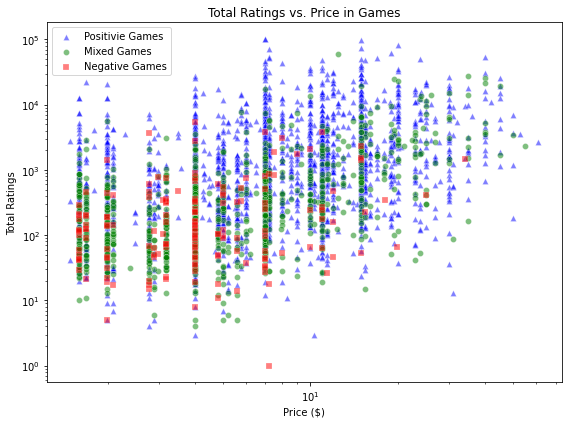

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting all three datasets on the same axes, with different colors
sns.scatterplot(x='price', y='total_ratings', data=success_game_data2, alpha=0.5, ax=ax, color="blue", marker = '^', label="Positivie Games")
sns.scatterplot(x='price', y='total_ratings', data=mixed_game_data2, alpha=0.5, ax=ax, color="green", marker = 'o', label="Mixed Games")
sns.scatterplot(x='price', y='total_ratings', data=fail_game_data2, alpha=0.5, ax=ax, color="red", marker = 's', label="Negative Games")

ax.set_title('Total Ratings vs. Price in Games')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Total Ratings')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

In [12]:
alter_list = ['two-sided', 'less', 'greater']

for alter in alter_list:
    result = do_ttest1(success_game_data2, 'average_playtime', 'median_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest1(fail_game_data2, 'average_playtime', 'median_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest2(success_game_data2, fail_game_data2, 'average_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest2(success_game_data2, fail_game_data2, 'median_playtime', alter)

    print(result)

Ttest_indResult(statistic=-2.5711924838867235, pvalue=0.010163633090759532)
Ttest_indResult(statistic=-2.5711924838867235, pvalue=0.005081816545379766)
Ttest_indResult(statistic=-2.5711924838867235, pvalue=0.9949181834546202)
----------------------
Ttest_indResult(statistic=-0.9399447103482033, pvalue=0.34795049053789606)
Ttest_indResult(statistic=-0.9399447103482033, pvalue=0.17397524526894803)
Ttest_indResult(statistic=-0.9399447103482033, pvalue=0.826024754731052)
----------------------
Ttest_indResult(statistic=4.745486425652237, pvalue=3.720071955792754e-06)
Ttest_indResult(statistic=4.745486425652237, pvalue=0.9999981399640221)
Ttest_indResult(statistic=4.745486425652237, pvalue=1.860035977896377e-06)
----------------------
Ttest_indResult(statistic=4.914530299498399, pvalue=1.7087082400472645e-06)
Ttest_indResult(statistic=4.914530299498399, pvalue=0.99999914564588)
Ttest_indResult(statistic=4.914530299498399, pvalue=8.543541200236323e-07)


In [13]:
success_game_data2.corr()

,appid,english,environ_Windows,environ_Mac,environ_Linux,required_age,achievements,positive_ratings,negative_ratings,total_ratings,positive_rating_ratio,average_playtime,median_playtime,price
appid,1.000000,-0.144696,NaN,-0.028422,-0.051376,-0.080423,0.041708,-0.172437,-0.159994,-0.174970,-0.007981,-0.025393,-0.000185,0.073580
english,-0.144696,1.000000,NaN,0.057634,0.039752,0.021171,-0.013551,0.013938,0.016935,0.014541,-0.015544,-0.028561,-0.032576,0.001569
environ_Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environ_Mac,-0.028422,0.057634,NaN,1.000000,0.693381,-0.101444,0.075301,0.089533,0.024931,0.085066,0.108278,0.002195,-0.009559,-0.103298
environ_Linux,-0.051376,0.039752,NaN,0.693381,1.000000,-0.088307,0.099303,0.101148,0.044963,0.097772,0.076818,0.018247,0.007387,-0.046169
required_age,-0.080423,0.021171,NaN,-0.101444,-0.088307,1.000000,0.064263,0.222149,0.244838,0.229262,0.014674,0.125168,0.096884,0.213569
achievements,0.041708,-0.013551,NaN,0.075301,0.099303,0.064263,1.000000,0.118474,0.144601,0.123662,-0.004474,0.094183,0.093916,0.174269
positive_ratings,-0.172437,0.013938,NaN,0.089533,0.101148,0.222149,0.118474,1.000000,0.759046,0.997902,0.229777,0.299772,0.128888,0.190242
negative_ratings,-0.159994,0.016935,NaN,0.024931,0.044963,0.244838,0.144601,0.759046,1.000000,0.799604,-0.042580,0.300636,0.161420,0.279686
total_ratings,-0.174970,0.014541,NaN,0.085066,0.097772,0.229262,0.123662,0.997902,0.799604,1.000000,0.207716,0.306412,0.134941,0.203296


In [14]:
fail_game_data2.corr()

,appid,english,environ_Windows,environ_Mac,environ_Linux,required_age,achievements,positive_ratings,negative_ratings,total_ratings,positive_rating_ratio,average_playtime,median_playtime,price
appid,1.000000,-0.055436,NaN,-0.051886,0.005228,-0.201678,0.173409,-0.294305,-0.318122,-0.316371,0.021851,0.126346,0.090519,-0.063734
english,-0.055436,1.000000,NaN,0.036801,0.036026,0.015317,0.010016,0.039176,0.038298,0.039252,0.334184,-0.014893,-0.006604,0.008165
environ_Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environ_Mac,-0.051886,0.036801,NaN,1.000000,0.723423,-0.090751,0.233906,-0.003790,0.023384,0.015350,0.124240,-0.004397,-0.012015,0.017254
environ_Linux,0.005228,0.036026,NaN,0.723423,1.000000,-0.088840,0.241300,-0.015908,0.018340,0.008016,-0.042019,-0.019439,-0.026790,-0.022495
required_age,-0.201678,0.015317,NaN,-0.090751,-0.088840,1.000000,-0.007329,0.379667,0.405944,0.404989,-0.068081,0.047594,0.072601,0.159360
achievements,0.173409,0.010016,NaN,0.233906,0.241300,-0.007329,1.000000,-0.032476,-0.037860,-0.036858,0.081154,-0.148929,-0.157889,0.045668
positive_ratings,-0.294305,0.039176,NaN,-0.003790,-0.015908,0.379667,-0.032476,1.000000,0.918401,0.960102,0.073554,-0.184792,-0.146850,0.193491
negative_ratings,-0.318122,0.038298,NaN,0.023384,0.018340,0.405944,-0.037860,0.918401,1.000000,0.992403,-0.093829,-0.192718,-0.142890,0.221655
total_ratings,-0.316371,0.039252,NaN,0.015350,0.008016,0.404989,-0.036858,0.960102,0.992403,1.000000,-0.043447,-0.193679,-0.146661,0.216838


In [15]:
mixed_game_data2.corr()

,appid,english,environ_Windows,environ_Mac,environ_Linux,required_age,achievements,positive_ratings,negative_ratings,total_ratings,positive_rating_ratio,average_playtime,median_playtime,price
appid,1.000000,-0.086440,NaN,-0.146835,-0.079775,-0.088981,0.116350,-0.131575,-0.116452,-0.126598,-0.129373,0.101315,0.086784,-0.076417
english,-0.086440,1.000000,NaN,-0.001279,0.032326,0.012724,0.004418,0.012388,0.009760,0.011419,0.030915,0.037905,0.040498,0.028230
environ_Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environ_Mac,-0.146835,-0.001279,NaN,1.000000,0.717124,-0.040792,0.007966,0.008326,-0.001008,0.004534,0.081257,-0.021284,-0.016249,0.004110
environ_Linux,-0.079775,0.032326,NaN,0.717124,1.000000,-0.052287,0.022725,-0.014353,-0.026208,-0.019414,0.103199,-0.004499,-0.006517,-0.013112
required_age,-0.088981,0.012724,NaN,-0.040792,-0.052287,1.000000,-0.001536,0.288422,0.280696,0.288064,0.012904,0.025232,0.021621,0.272720
achievements,0.116350,0.004418,NaN,0.007966,0.022725,-0.001536,1.000000,0.013126,0.012074,0.012819,0.043414,-0.018481,-0.018966,-0.003086
positive_ratings,-0.131575,0.012388,NaN,0.008326,-0.014353,0.288422,0.013126,1.000000,0.959809,0.993195,0.112828,0.265312,0.230021,0.431411
negative_ratings,-0.116452,0.009760,NaN,-0.001008,-0.026208,0.280696,0.012074,0.959809,1.000000,0.985964,0.023265,0.247081,0.217018,0.413017
total_ratings,-0.126598,0.011419,NaN,0.004534,-0.019414,0.288064,0.012819,0.993195,0.985964,1.000000,0.076775,0.260366,0.226896,0.428037


In [16]:
success_game_data3 = success_game_range(data, 0.7, 0)
fail_game_data3 = fail_game_range(data, 0.5, 0)

display(success_game_data3, fail_game_data3)

,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
1,20,Team Fortress Classic,1999-04-01,1,True,True,True,Valve,Valve,0,...,0.839787,277,62,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
2,30,Day of Defeat,2003-05-01,1,True,True,True,Valve,Valve,0,...,0.895648,187,34,5000000-10000000,3.99,fps,world_war_ii,multiplayer,action,shooter
3,40,Deathmatch Classic,2001-06-01,1,True,True,True,Valve,Valve,0,...,0.826623,258,184,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
4,50,Half-Life: Opposing Force,1999-11-01,1,True,True,True,Gearbox Software,Valve,0,...,0.947996,624,415,5000000-10000000,3.99,fps,action,sci_fi,singleplayer,classic
7,80,Counter-Strike: Condition Zero,2004-03-01,1,True,True,True,Valve,Valve,0,...,0.893871,427,43,10000000-20000000,7.19,action,fps,multiplayer,shooter,singleplayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,994220,NEOVERSE,2019-01-09,1,True,True,False,Tinogames Inc.,Tinogames Inc.,0,...,0.811321,162,162,0-20000,13.99,strategy,early_access,indie,card_game,rogue_lite
6157,994280,Ã¥ÂÂ¤Ã¥ÂÂÃ¥Â¥ÂÃ¨Â°Â­Ã¤Â¸Â(Gujian3),2018-12-14,0,True,False,False,Ã¤Â¸ÂÃ¦ÂµÂ·Ã§ÂÂÃ©Â¾ÂÃ¤Â¿Â¡Ã¦ÂÂ¯Ã§Â§ÂÃ¦Â...,Ã¥ÂÂÃ¤ÂºÂ¬Ã§Â½ÂÃ¥Â ÂÃ¥ÂÂ£Ã¥ÂÂÃ¥Â¨Â±Ã¤Â¹...,0,...,0.826923,614,823,100000-200000,23.79,rpg,action_rpg,story_rich,singleplayer,action
6158,995460,Miracle snack shop ÃªÂ¸Â°Ã¬Â ÂÃ¬ÂÂ Ã«Â¶ÂÃ¬...,2018-12-25,1,True,False,False,"TALESSHOP Co., Ltd.","TALESSHOP Co., Ltd.",0,...,0.973827,816,816,20000-50000,7.19,dating_sim,visual_novel,simulation,sexual_content,anime
6166,1020820,KumaKuma Manga Editor,2019-02-27,1,True,False,False,KumaKumaManga,SakuraGame,0,...,0.894057,43,43,20000-50000,4.79,design_&_illustration,web_publishing,animation_&_modeling,anime,pve


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
132,7530,Two Worlds II Castle Defense,2011-06-14,1,True,True,False,Reality Pump Studios,Topware Interactive,0,...,0.440922,320,330,200000-500000,6.99,strategy,tower_defense,fantasy,puzzle_platformer,real_time_tactics
180,10220,Postal III,2012-02-17,1,True,False,False,Trashmasters,Akella,18,...,0.367968,411,411,50000-100000,8.99,action,dark_humor,gore,open_world,funny
193,11590,Hospital Tycoon,2009-02-13,1,True,False,False,Deep Red Limited,Codemasters,0,...,0.367647,119,176,200000-500000,3.49,simulation,management,singleplayer,1980s,puzzle_platformer
275,18400,Crazy Machines 2,2008-06-20,1,True,False,False,Fakt Software,Viva Media,0,...,0.473171,66,66,100000-200000,7.19,casual,strategy,puzzle,physics,singleplayer
361,27330,Blacklight: Tango Down,2010-07-14,1,True,False,False,Zombie Studios,Ignition Entertainment,0,...,0.387097,129,193,50000-100000,0.79,action,fps,multiplayer,1980s,quick_time_events
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6116,921060,Modern Combat 5,2018-10-24,1,True,False,False,Gameloft,Gameloft,0,...,0.432135,129,69,200000-500000,0.00,free_to_play,massively_multiplayer,fps,action,shooter
6117,921590,DISSIDIA FINAL FANTASY NT Free Edition,2019-03-12,1,True,False,False,"Square Enix;KOEI TECMO GAMES CO., LTD.",Square Enix,0,...,0.381538,285,289,200000-500000,0.00,free_to_play,action,multiplayer,fighting,anime
6135,950100,PRO EVOLUTION SOCCER 2019 LITE,2018-12-13,1,True,False,False,Konami Digital Entertainment,Konami Digital Entertainment,0,...,0.399057,106,83,200000-500000,0.00,sports,free_to_play,multiplayer,soccer,singleplayer
6147,969880,Terrible Beast from the East,2019-01-03,1,True,False,False,Sleeping Hero,SakuraGame,0,...,0.488095,53,53,0-20000,1.69,action,massively_multiplayer,adventure,rpg,1980s


In [17]:
display(success_game_data3.corr(), fail_game_data3.corr())

,appid,english,environ_Windows,environ_Mac,environ_Linux,required_age,achievements,positive_ratings,negative_ratings,total_ratings,positive_rating_ratio,average_playtime,median_playtime,price
appid,1.000000,-0.136349,NaN,-0.046472,-0.071797,-0.089698,0.096030,-0.155961,-0.143166,-0.158666,-0.013683,-0.063554,-0.031235,-0.010031
english,-0.136349,1.000000,NaN,0.059348,0.041719,0.020412,0.003903,0.016311,0.019523,0.017082,-0.010200,-0.029629,-0.034185,0.003124
environ_Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environ_Mac,-0.046472,0.059348,NaN,1.000000,0.681467,-0.091958,-0.030429,0.087602,0.017401,0.082353,0.112505,-0.002914,-0.003373,-0.060726
environ_Linux,-0.071797,0.041719,NaN,0.681467,1.000000,-0.082230,-0.025081,0.084179,0.019686,0.079454,0.088664,0.008729,0.007540,-0.012909
required_age,-0.089698,0.020412,NaN,-0.091958,-0.082230,1.000000,-0.002693,0.211365,0.198005,0.215458,0.023783,0.121155,0.091288,0.210598
achievements,0.096030,0.003903,NaN,-0.030429,-0.025081,-0.002693,1.000000,0.013769,0.016128,0.014382,0.026342,-0.022573,-0.017957,-0.025912
positive_ratings,-0.155961,0.016311,NaN,0.087602,0.084179,0.211365,0.013769,1.000000,0.731485,0.997315,0.210563,0.273479,0.082340,0.135749
negative_ratings,-0.143166,0.019523,NaN,0.017401,0.019686,0.198005,0.016128,0.731485,1.000000,0.779456,-0.058608,0.285737,0.086440,0.167860
total_ratings,-0.158666,0.017082,NaN,0.082353,0.079454,0.215458,0.014382,0.997315,0.779456,1.000000,0.187160,0.281948,0.084934,0.142749


,appid,english,environ_Windows,environ_Mac,environ_Linux,required_age,achievements,positive_ratings,negative_ratings,total_ratings,positive_rating_ratio,average_playtime,median_playtime,price
appid,1.000000,-0.022006,NaN,-0.126081,-0.076078,-0.115408,0.090752,-0.065587,-0.099817,-0.084404,0.066346,0.057292,0.021503,-0.268207
english,-0.022006,1.000000,NaN,0.035122,0.030189,0.014576,0.008930,0.012117,0.016415,0.014506,0.068828,0.057182,0.059696,0.025166
environ_Windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environ_Mac,-0.126081,0.035122,NaN,1.000000,0.735240,-0.038768,0.021833,0.043262,0.041794,0.042769,0.070772,0.033255,0.037528,0.146532
environ_Linux,-0.076078,0.030189,NaN,0.735240,1.000000,-0.078911,0.034738,-0.017896,-0.007195,-0.012275,-0.031269,0.017077,0.023786,0.065765
required_age,-0.115408,0.014576,NaN,-0.038768,-0.078911,1.000000,-0.002843,0.208305,0.218557,0.215228,0.037469,-0.001569,0.007904,0.256741
achievements,0.090752,0.008930,NaN,0.021833,0.034738,-0.002843,1.000000,-0.002334,-0.006332,-0.004495,-0.005837,0.063085,-0.015598,-0.002396
positive_ratings,-0.065587,0.012117,NaN,0.043262,-0.017896,0.208305,-0.002334,1.000000,0.972873,0.992263,0.131954,0.106829,0.016029,0.253090
negative_ratings,-0.099817,0.016415,NaN,0.041794,-0.007195,0.218557,-0.006332,0.972873,1.000000,0.994067,0.053582,0.079952,0.009036,0.259166
total_ratings,-0.084404,0.014506,NaN,0.042769,-0.012275,0.215228,-0.004495,0.992263,0.994067,1.000000,0.090795,0.093134,0.012386,0.258077


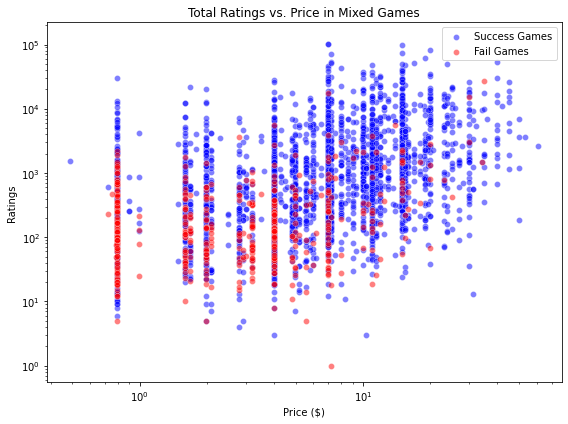

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting all three datasets on the same axes, with different colors
sns.scatterplot(x='price', y='total_ratings', data=success_game_data3, alpha=0.5, ax=ax, color="blue", label="Success Games")
# sns.scatterplot(x='price', y='total_ratings', data=mixed_game_data, alpha=0.5, ax=ax, color="red", label="Mixed Games")
sns.scatterplot(x='price', y='total_ratings', data=fail_game_data3, alpha=0.5, ax=ax, color="red", label="Fail Games")

ax.set_title('Total Ratings vs. Price in Mixed Games')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Ratings')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

In [19]:
alter_list = ['two-sided', 'less', 'greater']

for alter in alter_list:
    result = do_ttest1(success_game_data3, 'average_playtime', 'median_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest1(fail_game_data3, 'average_playtime', 'median_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest2(success_game_data3, fail_game_data3, 'average_playtime', alter)
    
    print(result)

print("----------------------")

for alter in alter_list:
    result = do_ttest2(success_game_data3, fail_game_data3, 'median_playtime', alter)

    print(result)

Ttest_indResult(statistic=-1.92705548219765, pvalue=0.05402144425133013)
Ttest_indResult(statistic=-1.92705548219765, pvalue=0.027010722125665066)
Ttest_indResult(statistic=-1.92705548219765, pvalue=0.9729892778743349)
----------------------
Ttest_indResult(statistic=-1.4650617409653086, pvalue=0.14319544405370702)
Ttest_indResult(statistic=-1.4650617409653086, pvalue=0.07159772202685351)
Ttest_indResult(statistic=-1.4650617409653086, pvalue=0.9284022779731466)
----------------------
Ttest_indResult(statistic=4.957258514617348, pvalue=8.272398604758725e-07)
Ttest_indResult(statistic=4.957258514617348, pvalue=0.9999995863800697)
Ttest_indResult(statistic=4.957258514617348, pvalue=4.1361993023793624e-07)
----------------------
Ttest_indResult(statistic=4.6119899236145265, pvalue=4.462057498660893e-06)
Ttest_indResult(statistic=4.6119899236145265, pvalue=0.9999977689712506)
Ttest_indResult(statistic=4.6119899236145265, pvalue=2.2310287493304465e-06)


In [20]:
for alter in alter_list:
    result = do_ttest2(success_game_data3, fail_game_data3, 'price', alter)
    
    print(result)

print("----------------------")
for alter in alter_list:
    result = do_ttest2(success_game_data3, fail_game_data3, 'total_ratings', alter)
    
    print(result)

Ttest_indResult(statistic=17.552328512366003, pvalue=3.288119939667625e-61)
Ttest_indResult(statistic=17.552328512366003, pvalue=1.0)
Ttest_indResult(statistic=17.552328512366003, pvalue=1.6440599698338126e-61)
----------------------
Ttest_indResult(statistic=15.027343237090612, pvalue=2.6516709383441796e-49)
Ttest_indResult(statistic=15.027343237090612, pvalue=1.0)
Ttest_indResult(statistic=15.027343237090612, pvalue=1.3258354691720898e-49)


### 이제부터는 호기심의 영역
- 통계 검정(t-test)과 시각화 자료로 둘의 차이가 있음이 나타났다.
    - 통계 검정
        - 성공한 게임이 실패한 게임보다 더 비쌌다.
        - 성공한 게임이 실패한 게임보다 리뷰의 수가 더 많음

In [21]:
# 정규성 검정 - kstest, shapiro

# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(success_game_data3['price'], 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(success_game_data3['price'])
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

Kolmogorov-Smirnov test: statistic=0.801962845243779, p-value=0.0
Shapiro-Wilk test: statistic=0.8367655873298645, p-value=0.0


In [22]:
# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(success_game_data3['total_ratings'], 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(success_game_data3['total_ratings'])
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

Kolmogorov-Smirnov test: statistic=0.9992800975124684, p-value=0.0
Shapiro-Wilk test: statistic=0.3859626054763794, p-value=0.0


In [23]:
# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(fail_game_data3['price'], 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(fail_game_data3['price'])
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(fail_game_data3['total_ratings'], 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(fail_game_data3['total_ratings'])
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

Kolmogorov-Smirnov test: statistic=0.7083674089946734, p-value=6.217263515596824e-274
Shapiro-Wilk test: statistic=0.6945732831954956, p-value=3.883513600653414e-30
Kolmogorov-Smirnov test: statistic=0.9981512845129382, p-value=0.0
Shapiro-Wilk test: statistic=0.24475204944610596, p-value=5.2058237949666954e-42


In [24]:
# 정규성을 만족하지 않으므로 비모수 검정 - mannwhitneyu, willcoxon

# 만 위트니 U 검정
u_statistic, u_pvalue = mannwhitneyu(success_game_data3['total_ratings'], fail_game_data3['total_ratings'])
print(f"Mann-Whitney U test: U={u_statistic}, p-value={u_pvalue}")

# 윌콕슨 부호 순위 검정
w_statistic, w_pvalue = wilcoxon(success_game_data3['total_ratings'] - fail_game_data3['total_ratings'])
print(f"Wilcoxon Signed-Rank test: W={w_statistic}, p-value={w_pvalue}")

# 만 위트니 U 검정
u_statistic, u_pvalue = mannwhitneyu(success_game_data3['total_ratings'], fail_game_data3['total_ratings'])
print(f"Mann-Whitney U test: U={u_statistic}, p-value={u_pvalue}")

# 윌콕슨 부호 순위 검정
w_statistic, w_pvalue = wilcoxon(success_game_data3['total_ratings'] - fail_game_data3['total_ratings'])
print(f"Wilcoxon Signed-Rank test: W={w_statistic}, p-value={w_pvalue}")

Mann-Whitney U test: U=1206426.5, p-value=4.637009105380872e-87
Wilcoxon Signed-Rank test: W=0.0, p-value=0.0
Mann-Whitney U test: U=1206426.5, p-value=4.637009105380872e-87
Wilcoxon Signed-Rank test: W=0.0, p-value=0.0


In [25]:
mixed_game_data = mixed_game_range(data, 0.4, 0.7, 0)
fail_game_data = fail_game_range(data, 0.4, 0)
success_game_data = success_game_range(data, 0.7, 0)

display(data, success_game_data, fail_game_data, mixed_game_data)

,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
1,20,Team Fortress Classic,1999-04-01,1,True,True,True,Valve,Valve,0,...,0.839787,277,62,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
2,30,Day of Defeat,2003-05-01,1,True,True,True,Valve,Valve,0,...,0.895648,187,34,5000000-10000000,3.99,fps,world_war_ii,multiplayer,action,shooter
3,40,Deathmatch Classic,2001-06-01,1,True,True,True,Valve,Valve,0,...,0.826623,258,184,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
4,50,Half-Life: Opposing Force,1999-11-01,1,True,True,True,Gearbox Software,Valve,0,...,0.947996,624,415,5000000-10000000,3.99,fps,action,sci_fi,singleplayer,classic
7,80,Counter-Strike: Condition Zero,2004-03-01,1,True,True,True,Valve,Valve,0,...,0.893871,427,43,10000000-20000000,7.19,action,fps,multiplayer,shooter,singleplayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6158,995460,Miracle snack shop ÃªÂ¸Â°Ã¬Â ÂÃ¬ÂÂ Ã«Â¶ÂÃ¬...,2018-12-25,1,True,False,False,"TALESSHOP Co., Ltd.","TALESSHOP Co., Ltd.",0,...,0.973827,816,816,20000-50000,7.19,dating_sim,visual_novel,simulation,sexual_content,anime
6163,1012710,Endzeit,2019-04-03,1,True,False,False,RockyDev,RockyDev,0,...,0.000000,88,88,0-20000,7.19,action,violent,early_access,bullet_time,first_person
6166,1020820,KumaKuma Manga Editor,2019-02-27,1,True,False,False,KumaKumaManga,SakuraGame,0,...,0.894057,43,43,20000-50000,4.79,design_&_illustration,web_publishing,animation_&_modeling,anime,pve
6167,1031480,Ã¦ÂÂ±Ã¦ÂÂ¹Ã¥Â¹ÂÃ¨ÂÂ¯Ã§Â¥Â­ Ã¦ÂÂ¥Ã©ÂÂªÃ§Â...,2019-03-18,1,True,False,False,Ã¤Â¸ÂÃ¦ÂÂ¹Ã¥Â¹ÂÃ¥ÂÂÃ§Â¥Â­Ã¥ÂÂ¶Ã¤Â½ÂÃ§Â»Â,Ã¤Â¸ÂÃ¦ÂÂ¹Ã¥Â¹ÂÃ¥ÂÂÃ§Â¥Â­Ã¥ÂÂ¶Ã¤Â½ÂÃ§Â»Â,0,...,0.970219,154,154,0-20000,10.29,indie,bullet_hell,faith,shoot_em_up,anime


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
1,20,Team Fortress Classic,1999-04-01,1,True,True,True,Valve,Valve,0,...,0.839787,277,62,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
2,30,Day of Defeat,2003-05-01,1,True,True,True,Valve,Valve,0,...,0.895648,187,34,5000000-10000000,3.99,fps,world_war_ii,multiplayer,action,shooter
3,40,Deathmatch Classic,2001-06-01,1,True,True,True,Valve,Valve,0,...,0.826623,258,184,5000000-10000000,3.99,action,fps,multiplayer,classic,shooter
4,50,Half-Life: Opposing Force,1999-11-01,1,True,True,True,Gearbox Software,Valve,0,...,0.947996,624,415,5000000-10000000,3.99,fps,action,sci_fi,singleplayer,classic
7,80,Counter-Strike: Condition Zero,2004-03-01,1,True,True,True,Valve,Valve,0,...,0.893871,427,43,10000000-20000000,7.19,action,fps,multiplayer,shooter,singleplayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,994220,NEOVERSE,2019-01-09,1,True,True,False,Tinogames Inc.,Tinogames Inc.,0,...,0.811321,162,162,0-20000,13.99,strategy,early_access,indie,card_game,rogue_lite
6157,994280,Ã¥ÂÂ¤Ã¥ÂÂÃ¥Â¥ÂÃ¨Â°Â­Ã¤Â¸Â(Gujian3),2018-12-14,0,True,False,False,Ã¤Â¸ÂÃ¦ÂµÂ·Ã§ÂÂÃ©Â¾ÂÃ¤Â¿Â¡Ã¦ÂÂ¯Ã§Â§ÂÃ¦Â...,Ã¥ÂÂÃ¤ÂºÂ¬Ã§Â½ÂÃ¥Â ÂÃ¥ÂÂ£Ã¥ÂÂÃ¥Â¨Â±Ã¤Â¹...,0,...,0.826923,614,823,100000-200000,23.79,rpg,action_rpg,story_rich,singleplayer,action
6158,995460,Miracle snack shop ÃªÂ¸Â°Ã¬Â ÂÃ¬ÂÂ Ã«Â¶ÂÃ¬...,2018-12-25,1,True,False,False,"TALESSHOP Co., Ltd.","TALESSHOP Co., Ltd.",0,...,0.973827,816,816,20000-50000,7.19,dating_sim,visual_novel,simulation,sexual_content,anime
6166,1020820,KumaKuma Manga Editor,2019-02-27,1,True,False,False,KumaKumaManga,SakuraGame,0,...,0.894057,43,43,20000-50000,4.79,design_&_illustration,web_publishing,animation_&_modeling,anime,pve


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
180,10220,Postal III,2012-02-17,1,True,False,False,Trashmasters,Akella,18,...,0.367968,411,411,50000-100000,8.99,action,dark_humor,gore,open_world,funny
193,11590,Hospital Tycoon,2009-02-13,1,True,False,False,Deep Red Limited,Codemasters,0,...,0.367647,119,176,200000-500000,3.49,simulation,management,singleplayer,1980s,puzzle_platformer
361,27330,Blacklight: Tango Down,2010-07-14,1,True,False,False,Zombie Studios,Ignition Entertainment,0,...,0.387097,129,193,50000-100000,0.79,action,fps,multiplayer,1980s,quick_time_events
365,27940,Dead Horde,2011-07-27,1,True,False,False,DnS Development,DnS Development,0,...,0.336601,82,82,50000-100000,4.79,action,zombies,indie,survival,multiplayer
506,46540,Trapped Dead,2011-07-15,1,True,False,False,Headup Games / Crenetic,Headup Games,0,...,0.386228,142,157,100000-200000,3.99,zombies,strategy,action,adventure,co_op
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6033,843500,God Vs Zombies,2018-05-10,1,True,False,False,Kev Jackson,Kev Jackson,0,...,0.265306,60,60,0-20000,2.89,early_access,action,strategy,simulation,indie
6112,911400,Assassin's CreedÃÂ® III Remastered,2019-03-29,1,True,False,False,Ubisoft Entertainment,Ubisoft Entertainment\t\t\t\t,0,...,0.325789,80,80,50000-100000,33.99,action,adventure,assassin,open_world,1980s
6117,921590,DISSIDIA FINAL FANTASY NT Free Edition,2019-03-12,1,True,False,False,"Square Enix;KOEI TECMO GAMES CO., LTD.",Square Enix,0,...,0.381538,285,289,200000-500000,0.00,free_to_play,action,multiplayer,fighting,anime
6135,950100,PRO EVOLUTION SOCCER 2019 LITE,2018-12-13,1,True,False,False,Konami Digital Entertainment,Konami Digital Entertainment,0,...,0.399057,106,83,200000-500000,0.00,sports,free_to_play,multiplayer,soccer,singleplayer


,appid,name,release_date,english,environ_Windows,environ_Mac,environ_Linux,developer,publisher,required_age,...,positive_rating_ratio,average_playtime,median_playtime,owners,price,Tag1,Tag2,Tag3,Tag4,Tag5
33,1690,Space Empires V,2006-10-16,1,True,False,False,Malfador Machinations,Strategy First,0,...,0.692029,35,35,50000-100000,10.99,strategy,4x,space,sci_fi,turn_based
36,1900,Earth 2160,2006-04-01,1,True,True,True,Reality Pump Studios,Topware Interactive;ACE,0,...,0.676630,405,414,1000000-2000000,3.99,strategy,rts,sci_fi,singleplayer,multiplayer
87,4520,Full Spectrum Warrior,2007-07-17,1,True,False,False,Pandemic Studios,THQ Nordic,0,...,0.638554,124,244,100000-200000,7.99,strategy,action,military,tactical,singleplayer
98,4890,Cossacks II: Battle for Europe,2011-08-26,1,True,False,False,GSC Game World,GSC World Publishing,0,...,0.640625,71,71,100000-200000,3.99,strategy,rts,historical,puzzle,racing
115,6550,Devil May CryÃÂ® 3 Special Edition,2007-06-12,1,True,False,False,"CAPCOM Co., Ltd.",Capcom,0,...,0.581543,90,90,200000-500000,15.99,action,hack_and_slash,great_soundtrack,stylized,spectacle_fighter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6116,921060,Modern Combat 5,2018-10-24,1,True,False,False,Gameloft,Gameloft,0,...,0.432135,129,69,200000-500000,0.00,free_to_play,massively_multiplayer,fps,action,shooter
6118,921630,Ã©ÂÂ³Ã§ÂÂµ INVAXION,2018-12-19,1,True,False,False,Nanjing AQUATRAX,bilibili,0,...,0.547649,760,760,100000-200000,11.29,music,rhythm,indie,casual,anime
6141,964470,Shakes and Fidget Remastered,2018-11-22,1,True,False,False,Playa Games GmbH,Playa Games GmbH,0,...,0.652733,50,91,50000-100000,0.00,free_to_play,casual,rpg,strategy,indie
6147,969880,Terrible Beast from the East,2019-01-03,1,True,False,False,Sleeping Hero,SakuraGame,0,...,0.488095,53,53,0-20000,1.69,action,massively_multiplayer,adventure,rpg,1980s


In [26]:
# 'price'에 대한 분산 분석(ANOVA)
anova_price_result = f_oneway(success_game_data['price'], fail_game_data['price'], mixed_game_data['price'])

# 'total_ratings'에 대한 분산 분석(ANOVA)
anova_total_ratings_result = f_oneway(success_game_data['total_ratings'], fail_game_data['total_ratings'], mixed_game_data['total_ratings'])

(anova_price_result.statistic, anova_price_result.pvalue, anova_total_ratings_result.statistic, anova_total_ratings_result.pvalue)

(101.56705274884939,
 7.257382508690808e-44,
 56.71674438777979,
 4.730455164322813e-25)

In [27]:
h_statistic, h_pvalue = kruskal(success_game_data['price'], fail_game_data['price'], mixed_game_data['price'])
print(f"Kruskal-Wallis H test: H={h_statistic}, p-value={h_pvalue}")

h_statistic, h_pvalue = kruskal(success_game_data['total_ratings'], fail_game_data['total_ratings'], mixed_game_data['total_ratings'])
print(f"Kruskal-Wallis H test: H={h_statistic}, p-value={h_pvalue}")

Kruskal-Wallis H test: H=338.8795635337868, p-value=2.589630275284062e-74
Kruskal-Wallis H test: H=570.6752491822131, p-value=1.2007266799712128e-124


### 정규성 변환 후 진행
- price, total_ratings를 정규화시켜 anova 분석 진행

In [28]:
log_price_success = np.log(success_game_data['price'] + 1)
log_price_fail = np.log(fail_game_data['price'] + 1)
log_price_mixed = np.log(mixed_game_data['price'] + 1)

log_ratings_success = np.log(success_game_data['total_ratings'] + 1)
log_ratings_fail = np.log(fail_game_data['total_ratings'] + 1)
log_ratings_mixed = np.log(mixed_game_data['total_ratings'] + 1)

In [29]:
# 'price'에 대한 분산 분석(ANOVA)
anova_price_result = f_oneway(log_price_success, log_price_fail, log_price_mixed)

# 'total_ratings'에 대한 분산 분석(ANOVA)
anova_total_ratings_result = f_oneway(log_ratings_success, log_ratings_fail, log_ratings_mixed)

(anova_price_result.statistic, anova_price_result.pvalue, anova_total_ratings_result.statistic, anova_total_ratings_result.pvalue)

(159.16682460813223,
 1.6601940224084348e-67,
 309.01334137066885,
 1.9144231137426437e-126)

In [30]:
# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(log_price_success, 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(log_price_success)
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(log_price_fail, 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(log_price_fail)
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

# 콜모고로프-스미르노프 검정
ks_stat, ks_p = kstest(log_price_mixed, 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p}")

# 샤피로-윌크 검정
shapiro_stat, shapiro_p = shapiro(log_price_mixed)
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

Kolmogorov-Smirnov test: statistic=0.6872449880852212, p-value=0.0
Shapiro-Wilk test: statistic=0.9607269763946533, p-value=2.2604187163736056e-27
Kolmogorov-Smirnov test: statistic=0.671874560823235, p-value=4.702921044471876e-107
Shapiro-Wilk test: statistic=0.9507342576980591, p-value=2.9862013661841047e-07
Kolmogorov-Smirnov test: statistic=0.6024499608572939, p-value=0.0
Shapiro-Wilk test: statistic=0.962244987487793, p-value=3.738308775174175e-18


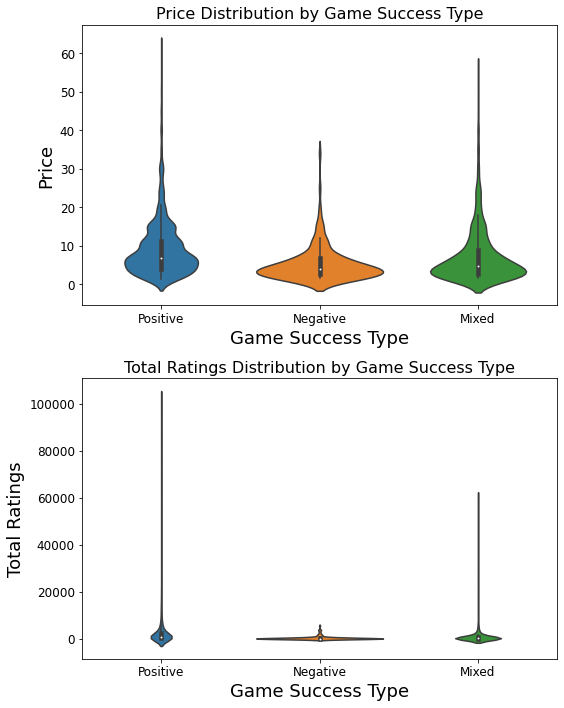

In [31]:
plt.figure(figsize=(8, 10))

plt.rc('font', size=12)  # 기본 폰트 크기
plt.rc('axes', titlesize=16)  # 축 제목 폰트 크기
plt.rc('axes', labelsize=18)  # 축 라벨 폰트 크기
plt.rc('xtick', labelsize=12)  # x축 눈금 라벨 폰트 크기
plt.rc('ytick', labelsize=12)  # y축 눈금 라벨 폰트 크기
plt.rc('legend', fontsize=14)  # 범례 폰트 크기

# 'price'에 대한 바이올린 플롯
plt.subplot(2, 1, 1)
sns.violinplot(data=[success_game_data2['price'], fail_game_data2['price'], mixed_game_data2['price']])
plt.xticks([0, 1, 2], ['Positive', 'Negative', 'Mixed'])
plt.title('Price Distribution by Game Success Type')
plt.ylabel('Price')
plt.xlabel('Game Success Type')

# 'total_ratings'에 대한 바이올린 플롯
plt.subplot(2, 1, 2)
sns.violinplot(data=[success_game_data2['total_ratings'], fail_game_data2['total_ratings'], mixed_game_data2['total_ratings']])
plt.xticks([0, 1, 2], ['Positive', 'Negative', 'Mixed'])
plt.title('Total Ratings Distribution by Game Success Type')
plt.ylabel('Total Ratings')
plt.xlabel('Game Success Type')

plt.tight_layout()
plt.show()

In [32]:
temp = pd.DataFrame({
    'value': np.concatenate([success_game_data2['price'], fail_game_data2['price'], mixed_game_data2['price']]),
    'group': ['Success']*len(success_game_data2) + ['Fail']*len(fail_game_data2) + ['Mixed']*len(mixed_game_data2)
})

# Tukey HSD 검정 수행
tukey_result = pairwise_tukeyhsd(endog=temp['value'], groups=temp['group'], alpha=0.05)
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1  group2 meandiff p-adj  lower  upper  reject
---------------------------------------------------
  Fail   Mixed   2.0709 0.0022 0.6309 3.5109   True
  Fail Success   4.1372    0.0 2.7666 5.5078   True
 Mixed Success   2.0663    0.0  1.415 2.7175   True
---------------------------------------------------


In [33]:
display(
    pearsonr(success_game_data2['price'], success_game_data2['total_ratings']),
    pearsonr(fail_game_data2['price'], fail_game_data2['total_ratings']),
    pearsonr(mixed_game_data2['price'], mixed_game_data2['total_ratings'])
)


(0.20329592557053516, 1.0794940898822149e-24)

(0.21683752111911359, 0.00557859945196265)

(0.42803742421991736, 2.0488226080045927e-42)